In [1]:
import pandas as pd
import re
import datetime

# plotting
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# for sankey diagram 
from sankey import genSankey
import plotly
#import plotly.plotly as py
#import chart_studio.plotly as py

# pandas display 
pd.options.display.max_colwidth = 100

In [2]:
from iwantout import load_and_transform_raw_data,save_outputs_from_generator
%load_ext autoreload
%autoreload 2

In [3]:
# test data
transformed_csv = 'output/transformed.csv'

## Load transfromed data

In [4]:
df = pd.read_csv(transformed_csv)

## Trend analysis

In [5]:
df['created_dt'] = pd.to_datetime(df['created_dt'])

In [6]:
 df['start_of_week'] = df['created_dt'] - df['created_dt'].dt.weekday.astype('timedelta64[D]')

In [23]:
time_unit = 'created_dt'
df_trend_analysis = df.groupby([time_unit, 'destination_region']).agg('count')[['index']].reset_index().rename({'index': 'count'}, axis='columns')

In [24]:
destination_regions = list(df['destination_region'].dropna().unique())
print(destination_regions)

['South America', 'Europe', 'North America', 'Asia', 'Oceania', 'European Union', 'Africa', 'Scandinavia']


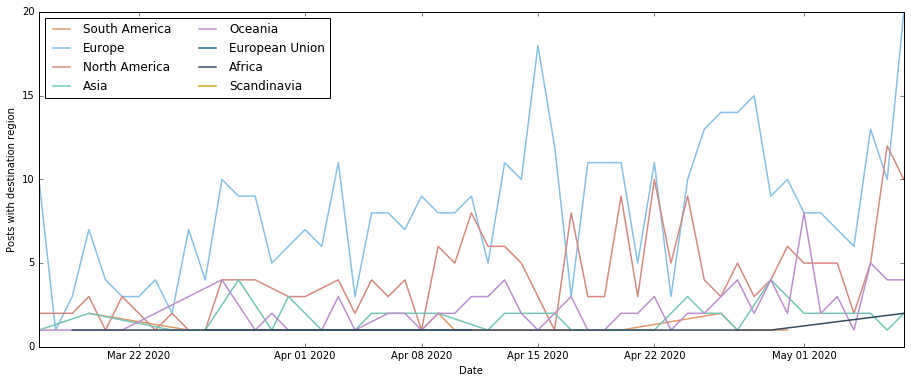

In [42]:
colours = ['#E59866','#85C1E9','#D98880', '#73C6B6', '#BB8FCE','#1F618D', '#34495E','#D4AC0D']
fig, ax = plt.subplots()

for i in range(len(destination_regions)):
    dest = destination_regions[i]
    df_plot = df_trend_analysis[df_trend_analysis['destination_region'] == dest]
    x, y = df_plot[time_unit], df_plot['count']
    
    
    ax.plot(x, y, colours[i], label=dest, linewidth=1.5)

fig = plt.gcf()
fig.set_size_inches(15.5, 6, forward=True)
leg = ax.legend(loc = "upper left", ncol=2)
plt.xlabel("Date")
plt.ylabel("Posts with destination region")
plt.show()

## Sankey diagram

In [44]:
agg_cols = ['origin_region', 'origin_country', 'destination_region', 'destination_country']
grouped = df.groupby(agg_cols).count()['index']

In [45]:
grouped = grouped.reset_index().rename({'index': 'count'}, axis='columns')

In [46]:
grouped["origin_region"] = grouped.apply(lambda x: "Origin: " + x['origin_region'], axis = 1)

In [47]:
grouped["origin_country"] = grouped.apply(lambda x: "Origin: " + x['origin_country'], axis = 1)

In [50]:
grouped["destination_region"] = grouped.apply(lambda x: "Destination: " + x['destination_region'], axis = 1)

In [51]:
grouped["destination_country"] = grouped.apply(lambda x: "Destination: " + x['destination_country'], axis = 1)

In [52]:
fig = genSankey(grouped,cat_cols=agg_cols,value_cols='count',title='Where do redditors want to go?')
plotly.offline.plot(fig, validate=False)

# note: renamed 'temp-plot.html' to 'iwantout-sankey.html'

'temp-plot.html'

## Keyword extraction

In [53]:
from process_text import tokenize, remove_special_characters,spacy_tokeniser, clean_my_string

In [65]:
def generate_document_by_region(dest_region):
    contents = list(df[df['destination_region'] == dest_region]['contents'].values)

    # remove duplicates (exist because of exploded destination)
    contents = list(set(contents))
    
    # clean and combine all contents into one list 
    cleaned_combined = []
    for c in contents:
        cleaned = clean_my_string(c)
        cleaned_combined += cleaned
    
    return cleaned_combined

In [66]:
text_by_region = []
for dest_region in destination_regions:
    cleaned_combined = generate_document_by_region(dest_region)
    text_by_region.append(" ".join(cleaned_combined))

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
vectorizer = TfidfVectorizer(tokenizer=clean_my_string)
X = vectorizer.fit_transform(text_by_region)
feature_names = vectorizer.get_feature_names()

In [68]:
k = 10
top = []
for x in X.toarray():
    pair = dict()
    
    n = np.array(x)
    
    # top k indexes with highest value
    topk = np.argsort(n)[-k:]
    tfidf = n[topk]
    key = list(np.array(feature_names)[topk])
    
    for i,j in zip(key,tfidf):
        pair[i] = j
    top.append(pair)


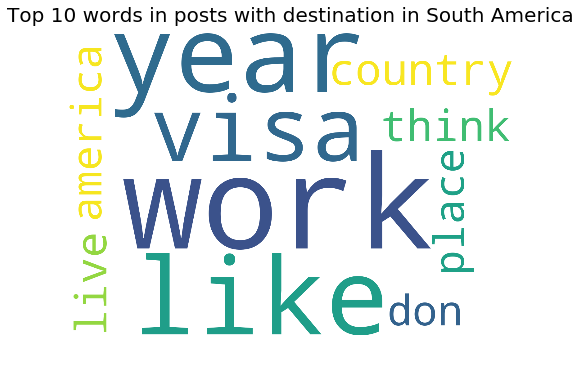

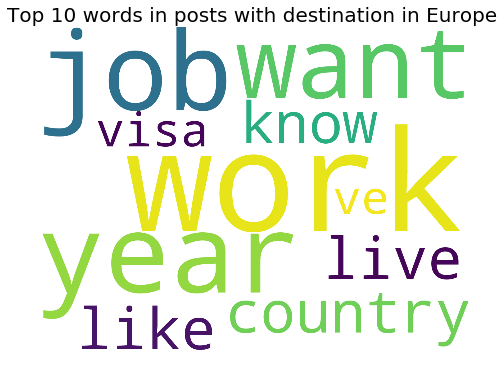

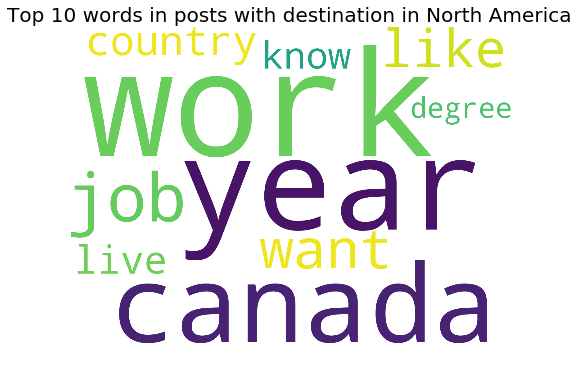

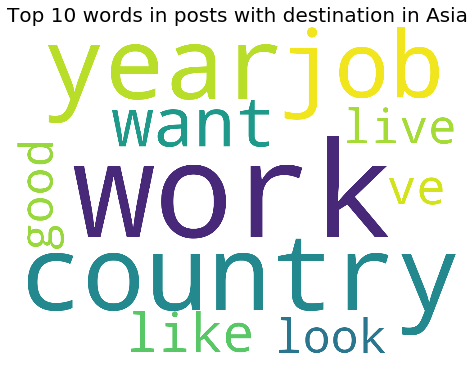

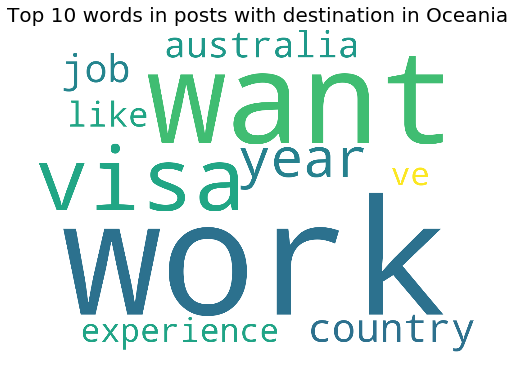

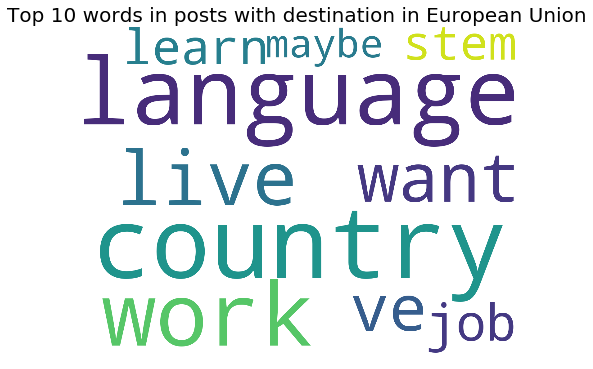

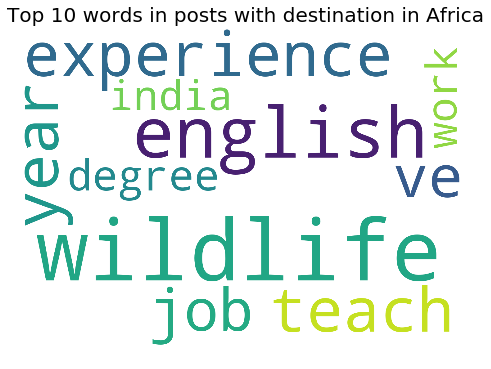

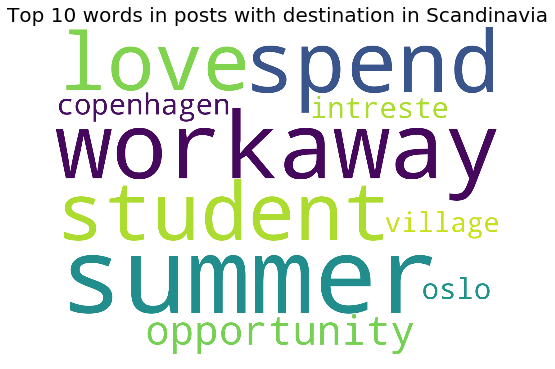

In [71]:
from wordcloud import WordCloud
for t,region in zip(top, destination_regions):
    cloud = WordCloud(width=1440, height=1080, background_color='white').generate_from_frequencies(t)
    plt.figure(figsize=(8, 8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(f"Top {k} words in posts with destination in {region}", fontsize=20)
    plt.show();
    print("\n")